In [ ]:
#220809:
#For the purposes of the analysis, do not include the Retiring (TBC) category for the moment
#Retiring affects predictions in the future i.e. > Aug 2022
#It does not affect the data we are using as we are predicting data up Aug 22 in these analyses

# Clustering with Business Rules

Can we ghet better results if we are more selective? Apply some intelligence to what we do and do not try to forecast?

To continue the thread from above/ for comparison I'll focus on ISBNs in Spain (ES)

In [ ]:
#Import libraries
from helpers import *

from sqlalchemy import create_engine
import psycopg2
import numpy as np
import pandas as pd
import datetime as dt
import dateutil

import random #I'm going to us this for dev and testing

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import ExponentialSmoothing as hwes
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

#This is suppress all warnings in the notebook - turn when happy code works
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Redshift user credentials - set here
USER = 
PASSWORD = 

FCST_PERIOD = 9   #How many months I want to forecast ahead

In [ ]:
#Create SQLAlchemy engine for Redshift database
user = USER
password = PASSWORD
host= 
port='5439'
dbname='prod'

url = "postgresql+psycopg2://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, dbname)
engine = create_engine(url)

# A. Get all ISBN/ Country Data

## A.1 Read in all the product/ country combinations in Redshift

In [ ]:
query = """
    select distinct
      t1.isbn + t1.ship_to_country_key as key,
      t1.isbn,
      isbn_short,
      t1.ship_to_country_key as country,
      scr_site_ref,
      pub_center_key,
      division_key,
      subject_2_key,  
      series_key,
      family_key,
      isbn_comment
    from r2ibp.f_demand_actual t1
    left join r2ibp.lu_product t2
    on t1.isbn = t2.isbn13
    left join r2ibp.v_udf_isbn_latest t3
    on t1.isbn = t3.isbn13
    left join r2ibp.lu_elt_country_hierarchy t4
    on t1.ship_to_country_key = t4.ship_to_country_key
    where t1.isbn not like '555%%'
"""
#NB % by itself causes an sqlalchemy error - use %% instead

conn = engine.connect()
df = pd.read_sql_query(query, conn)
conn.close()

df = df.fillna('') #Particularly to fill the isbn_comment field

## A.2 Get the demand in the last 12 full months

In [ ]:
# Add the demand from the last twelve months
#This I could do with a cursor rather than separate connection

query = f"""
    select distinct
      isbn + ship_to_country_key as key,
      sum(quantity_demanded) as qty_last_12m
    from r2ibp.f_demand_actual 
    where isbn not like '555%%'
    and last_day(date) > dateadd(month, -12, current_date)
    and last_day(date) <= current_date
    group by key
"""
conn = engine.connect()
df_temp = pd.read_sql_query(query, conn)
conn.close()

df_clusters = df.merge(df_temp, how = 'left').fillna(0) #If no demand in 12 momnths store as 0
#df_clusters.head()

## A.3 Add data from files

In [ ]:
#These two csv files have not been updated since the end of Nov 2021.
#There's a good chance that there will be missing values!

df_temp = pd.read_excel("data/Pub Date from Pubsys.xlsx")
df_temp.rename(columns = {'ISBN':'isbn', 'Global Publication Date':'Pub Date'}, inplace = True)
df_temp['isbn'] = df_temp['isbn'].astype('str')

df_clusters = df_clusters.merge(df_temp, how = 'left')

df_temp = pd.read_excel("data/List of RPL-MOD ISBNs.xlsx")
df_temp.rename(columns = {'ISBN':'isbn'}, inplace = True)
df_temp['isbn'] = df_temp['isbn'].astype('str')

df_clusters = df_clusters.merge(df_temp, how = 'left').fillna('')
#df_clusters.head()

# B Cluster

## B.1 Cluster using Business Rules

These are the clusters for the variations in the forecasting algorithms

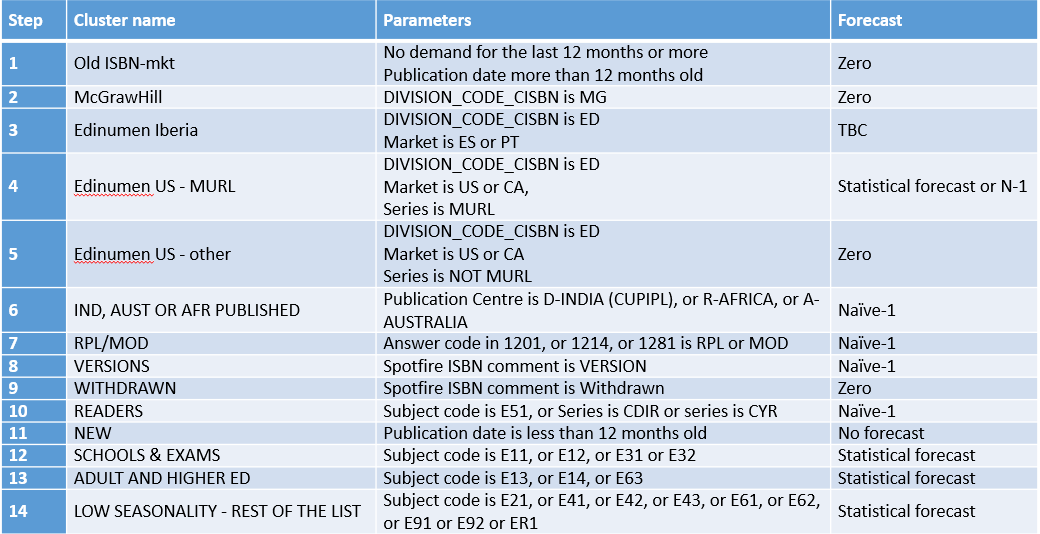

Start by excluding the follow from the dataset

No demand in the last 12 months (we can revisist the Pub Date criterion c.f. Cluster 11)
DIVISION_CODE_CISBN in ('MG', 'ED')
Publication Centre is India, Africa, Australia
Answer code in 1201, 1214 or 1281 is in ('RPL', 'MOD')
Has ISBN comment (as proxy for is VERSION or Withdrawn or Retiring). To check with Delphine
Subject Code is E51 or Series is in ('CDIR', 'CYR')
This shoud leave us with Clusters 12, 13 and 14. NB There is a NEW cluster as well. We'll start by forecasting all these clusters in the same way.

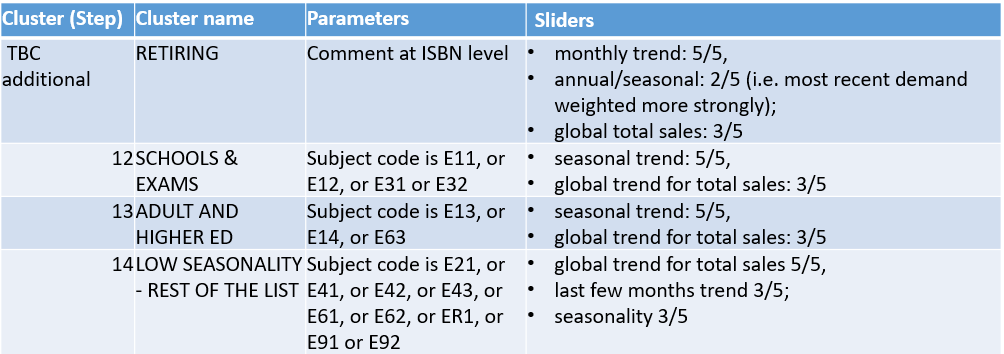

In [ ]:
cluster_names = {
    "1": "Old ISBN-mkt",
    "2": "McGrawHill",
    "3": "Edinumen Iberia",
    "4": "Edinumen US - MURL",
    "5": "Edinumen US - other",
    "6": "IND, AUST OR AFR PUBLISHED",
    "7": "RPL/MOD",
    "8": "VERSIONS",
    "9": "WITHDRAWN",
    "10": "READERS",
    "11": "NEW",
    "TBC": "Retiring",
    "12": "SCHOOLS & EXAMS",
    "13": "ADULT AND HIGHER ED",
    "14": "LOW SEASONALITY - REST OF THE LIST",  
    "15": "Unallocated"
}

In [ ]:
#Calculate date a full 12 calendar months ago
current_date = dt.datetime.today()
dt_twelve_months_ago = dt.datetime(current_date.year, current_date.month, 1)\
                            - dateutil.relativedelta.relativedelta(months=12)

#Ensure isbn_comment in correct format
df_clusters['isbn_comment'] = df_clusters['isbn_comment'].astype('str')

def cluster(row):
    if (row['qty_last_12m'] <= 0) & (row['Pub Date'] < dt_twelve_months_ago):
        return "1"
    elif (row['division_key'] == 'MG'):
        return "2"
    elif (row['division_key'] == 'ED') & (row['country'] in ['ES', 'PT']):
        return "3"
    elif (row['division_key'] == 'ED') & (row['country'] in ['US', 'CA']) & (row['series_key'] == 'MURL'):
        return "4"
    elif (row['division_key'] == 'ED') & (row['country'] in ['US', 'CA']) & (row['series_key'] != 'MURL'):
        return "5"
    elif (row['pub_center_key'] in ['A', 'D', 'R']):
        return "6"
    elif (row['RPL/MOD'] == 'RPL / MOD'):
        return "7"
    elif row['isbn_comment'].lower().startswith('version'):
        return "8"
    elif row['isbn_comment'].lower().startswith('withdrawn'):   
        return "9"
    elif (row['subject_2_key'] == 'E51') | (row['series_key'] in ['CDIR', 'CYR']):
        return "10"
    elif (row['Pub Date'] >= dt_twelve_months_ago):
        return "11"
#     elif row['isbn_comment'] != '': #All remaining rows with comments - ask DA to provide the rules here
#         return "TBC"
    elif (row['subject_2_key'] in ['E11', 'E12', 'E31', 'E32']):
        return "12"
    elif (row['subject_2_key'] in ['E13', 'E14', 'E63']):
        return "13"
    elif (row['subject_2_key'] in ['E21', 'E41', 'E42', 'E43', 'E61', 'E62', 'E91', 'E92', 'ER1']):
         return "14"
    else:
        return "15"

In [ ]:
df_clusters['cluster'] = df_clusters.apply(cluster, axis=1)
df_clusters['description'] = df_clusters[['cluster']].replace({'cluster': cluster_names})

print('There are', len(df_clusters), 'ISBN/country combinations')

print('The full breakdown of the clustering is as follows:')
print('\n')
print(df_clusters['description'].value_counts())

## B.2 Cluster using 12m Demand

I want to add in the demand element too

NB I've done this before filtering down to clusters 12, 13 , 14 and TBC

In [ ]:
df_clusters['bin'] = pd.cut(df_clusters['qty_last_12m'], [0, 10, 100, 1000, 10000, 100000],
                           labels = ['<=10', '10-100', '100-1000', '1000-10000', '>10000'])

In [ ]:
df_clusters.head()

#NB Cluster 1 hasn't been binned

# C. Look at the "to forecast" clusters

The Demand Planners think only 12, 13, 14 and TBC are forecastable.

I only think those with higher demand and a "good shape"

In [ ]:
df_to_forecast = df_clusters.copy()
df_to_forecast = df_to_forecast[df_to_forecast['cluster'].isin(["TBC", "12", "13", "14"])]
                                                               

## C.1 Distribution of demand

This is looking at the demand in the last 12 months

In [ ]:
print('Crosstab of last year\'s demand by cluster\n')
print(pd.crosstab(df_to_forecast['cluster'], columns=df_to_forecast['bin'], values=df_to_forecast['key'], aggfunc='count'))
print('\nComparative pie charts\n')

fig, axes = plt.subplots(1, 3, figsize = (16,4))
#The following is to iterate the axes
axes_flat = axes.flat

for i, a in enumerate(df_to_forecast['cluster'].sort_values().unique()):
       
    ax = axes_flat[i]
    
    y = df_to_forecast[df_to_forecast['cluster'] == a]['bin'].value_counts()
    my_labels = ['<=10', '10-100', '100-1000', '1000-10000', '>10000']
    
    ax.pie(y, labels = my_labels)
    ax.set_title(a)
         
plt.tight_layout()
plt.show();

# D. Let's look at a Cluster

- Spain

## D.1 Select the ISBN/countries

Need to create the key list to pass to the forecasting algorithm



In [ ]:
#Code if want to downselect based on various criteria
# msk = (df_to_forecast['country'] == 'ES') \
#         & (df_to_forecast['cluster'] == '12') \
#         & (df_to_forecast['qty_last_12m'] >= 100)
#key_list = df_to_forecast[msk]['key'].to_list()

#For the report use a random sample the same size as Spain from ghe previous notebook
key_list = random.sample(list(df_to_forecast['key']), 3072) #For testing

print(len(key_list), 'isbn/countries selected to forecast')

## D.2 Forecast and Compare Accuracy

In [ ]:
df_demand = get_demand(key_list, engine)

df_errors, df_hwes_forecasts = predict_using_hwes(df_demand, FCST_PERIOD)

df_metrics = calc_prediction_metrics(df_hwes_forecasts)

plot_pred_naive1(df_metrics)

In [ ]:
df_metrics.head()

# E Looking across clusters

Are there differences between and within the clusters?

In [ ]:
df_comparison = df_metrics.copy()[['key', 'abs_pred_closer', 'pred_rmse_lower']]
df_comparison[['abs_pred_closer', 'pred_rmse_lower']] = df_comparison[['abs_pred_closer', 'pred_rmse_lower']].replace({True: 1, False: 0})
df_comparison = df_comparison.merge(df_to_forecast[['key', 'country', 'cluster', 'bin']], how = 'left')

df_comparison.head()

In [ ]:
#Accuracy better by cluster and/or total order amount?

df_a = pd.crosstab(df_comparison['cluster'], columns=df_comparison['bin'], values=df_comparison['abs_pred_closer'], aggfunc='sum')
df_b = pd.crosstab(df_comparison['cluster'], columns=df_comparison['bin'], values=df_comparison['pred_rmse_lower'], aggfunc='sum')
df_c = pd.crosstab(df_comparison['cluster'], columns=df_comparison['bin'], values=df_comparison['key'], aggfunc='count')

print("Total number of timeseries for each cluster by last year's demand\n")
print(df_c)
print('\n')
print("Crosstab of % statistical forecasts where rmse better than naive-1\n")
print(((df_b/df_c)*100).round(1))
print('\n')
print("Crosstab of % statistical forecasts where totals better than naive-1\n")
print(((df_a/df_c)*100).round(1))

In [ ]:
# What about by country?

df_a = pd.crosstab(df_comparison['country'], columns=df_comparison['bin'], values=df_comparison['abs_pred_closer'], aggfunc='sum')
df_b = pd.crosstab(df_comparison['country'], columns=df_comparison['bin'], values=df_comparison['pred_rmse_lower'], aggfunc='sum')
df_c = pd.crosstab(df_comparison['country'], columns=df_comparison['bin'], values=df_comparison['key'], aggfunc='count')
#These dfs are alphabetical by country

#Convert to percentages
df_d = ((df_a/df_c)*100).round(1)
df_e = ((df_b/df_c)*100).round(1)

msk = (df_c['<=10'] >= 25) # get the biggest countries - play with the parameter

df_d = df_d[msk]
df_e = df_e[msk]

print("NB THIS ANALYSIS IS FOR COUNTRIES WITH MOST ISBN/COUNTRY COMBOS\n")

print("Total number of isbns for each country in the sample by last year's demand\n")
print(df_c[msk])
print('\n')
print("Crosstab of % statistical forecasts where rmse better than naive-1 by country and last year's demand\n")
print(df_e)
print('\n')
print("Crosstab of % statistical forecasts where totals better than naive-1 by country and last year's demand\n")
print(df_d)


# E Timeseries Plots

In [ ]:
#Select the ISBN/country combinations to plot from those forecasted using key_list

plot_list = key_list[:10]

plot_sample_preds(plot_list, df_demand, df_hwes_forecasts, FCST_PERIOD)

df_metrics[df_metrics['key'].isin(plot_list)]

#The low forecast accuracies I'm getting are due to the -ves (which I was zeroing before)